In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import os
import torch
import scipy
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import matplotlib.dates as mdates
import statsmodels.api as sm
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose, MSTL, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
import math
import yfinance as yf
import datetime as dt

1. Load Data

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
train = pd.read_csv('/content/drive/MyDrive/RNN/train.csv')
print(len(train))
train.head()

43775


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [62]:
test = pd.read_csv('/content/drive/MyDrive/RNN/Test_Jan.csv')
print(len(test))
test.head()

744


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,01-01-2020 00:00,0,25.809259,0.018042,0.032806,14.849625,23.301447,0.017035,0.021866,4.559083,22.598322,0.016195,0.068054,3.737708,1,1,0
1,01-01-2020 01:00,0,25.650842,0.018065,0.053177,15.933757,23.041467,0.016936,0.023796,4.846412,22.471155,0.016104,0.080109,3.591759,1,1,0
2,01-01-2020 02:00,0,25.501489,0.018119,0.069000,16.806818,22.806177,0.016822,0.024910,5.204608,22.368677,0.016013,0.094757,3.704177,1,1,0
3,01-01-2020 03:00,0,25.430994,0.018142,0.080017,17.460632,22.657556,0.016746,0.025208,5.628076,22.282556,0.015937,0.107086,3.936592,1,1,0
4,01-01-2020 04:00,0,25.360132,0.018204,0.084137,16.632112,22.539819,0.016647,0.022789,5.729821,22.203882,0.015862,0.113800,4.088643,1,1,0


In [63]:
predict = pd.read_csv('/content/drive/MyDrive/RNN/Predict_Jan.csv')
print(len(predict))
predict.head()

744


,datetime,nat_demand
0,01-01-2020 00:00,1032.2630
1,01-01-2020 01:00,1017.5806
2,01-01-2020 02:00,1000.2797
3,01-01-2020 03:00,987.2383
4,01-01-2020 04:00,970.3667


==== VISUALISASI DATA

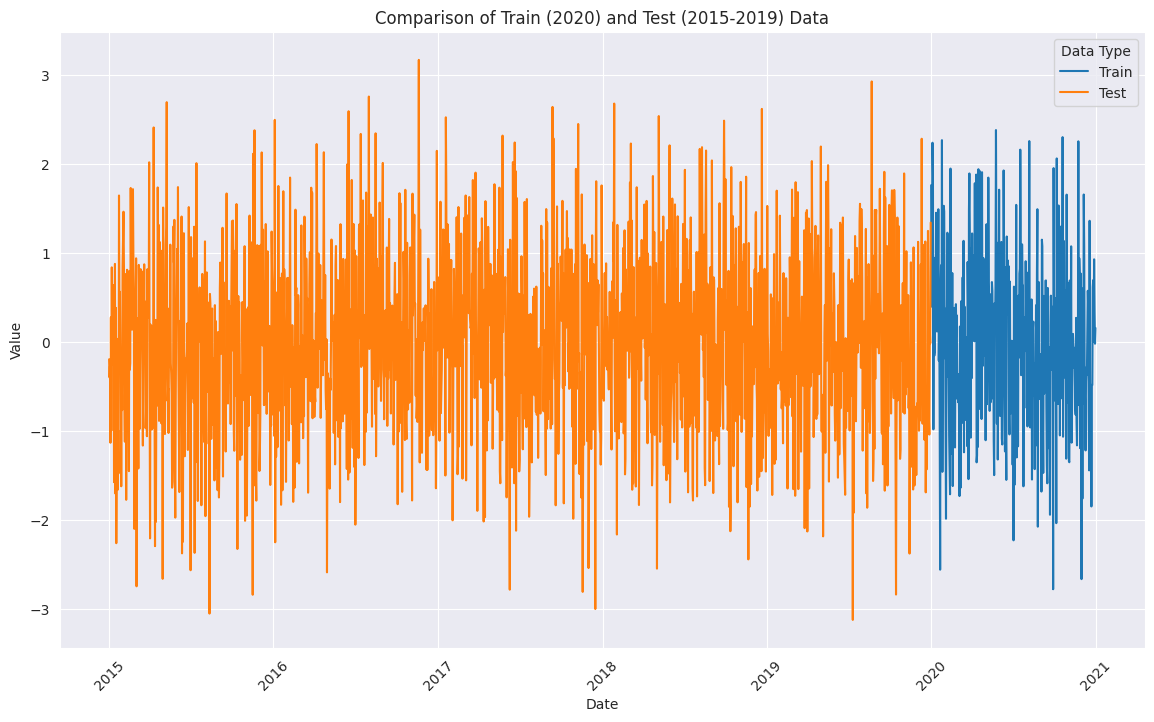

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
# Generate random data for demonstration purposes
np.random.seed(0)
train_data = np.random.randn(366)  # 2020 is a leap year

# Calculate the number of days in the test period (2015-2019)
test_period_start = pd.to_datetime('2015-01-01')
test_period_end = pd.to_datetime('2019-12-31')
num_test_days = (test_period_end - test_period_start).days + 1

test_data = np.random.randn(num_test_days)

# Generate date ranges
train_dates = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
test_dates = pd.date_range(start='2015-01-01', end='2019-12-31', freq='D')

# Ensure the lengths match
assert len(train_dates) == len(train_data)
assert len(test_dates) == len(test_data)

# Create DataFrames for easier plotting
train_df = pd.DataFrame({
    'Date': train_dates,
    'Value': train_data,
    'Type': 'Train'
})

test_df = pd.DataFrame({
    'Date': test_dates,
    'Value': test_data,
    'Type': 'Test'
})

# Combine the data
data = pd.concat([train_df, test_df])

# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=data, x='Date', y='Value', hue='Type')
plt.title('Comparison of Train (2020) and Test (2015-2019) Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(title='Data Type')
plt.xticks(rotation=45)
plt.show()

In [66]:
print("Holiday ID:", train['Holiday_ID'].unique())
print("Holiday:", train['holiday'].unique())
print("School:", train['school'].unique())


Holiday ID: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  1]
Holiday: [0 1]
School: [0 1]


In [67]:
train[['Holiday_ID','holiday','school']].value_counts()

Holiday_ID  holiday  school
0           0        1         30864
                     0         10175
21          1        0           144
19          1        1           144
16          1        1           144
12          1        1           144
20          1        0           120
18          1        1           120
17          1        1           120
15          1        1           120
14          1        1           120
13          1        1           120
11          1        1           120
10          1        1           120
9           1        1           120
8           1        1           120
7           1        0           120
6           1        0           120
5           1        0           120
4           1        0           120
3           1        0           120
2           1        0           120
1           1        0           120
22          1        0           120
Name: count, dtype: int64

In [68]:
train.index=pd.to_datetime(train['datetime'],format="%d-%m-%Y %H:%M")
train=train.drop('datetime',axis=1)

In [69]:
# setting 80% of the data as training data
import math
train_data_len = math.ceil(len(train) * .8)
train_data_len

# splitting the dataset
train_split = train[:train_data_len].iloc[:,:1]
test_split = train[train_data_len:].iloc[:,:1]
print(train_split.shape, test_split.shape)

(35020, 1) (8755, 1)


Minmax Scaller

In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

train_scaled = scaler.fit_transform(train_split)

print(train_scaled[:5])

[[0.46624951]
 [0.42026148]
 [0.41084821]
 [0.40269331]
 [0.40564433]]


In [71]:
test_data = test_split.iloc[:, 0].values  # Select all rows (:) and the first column (0)

# reshape to 2d array
test_data = np.reshape(test_data, (-1,1))

# applying minmax in test
test_scaled = scaler.fit_transform(test_data)
print(*test_scaled[:5])

[0.51709748] [0.50681546] [0.5030024] [0.53370453] [0.55487455]


======= Devided x_train and y_train

In [72]:
X_train = []
y_train = []
for i in range(50, len(train_scaled)):
    X_train.append(train_scaled[i-50:i, 0])
    y_train.append(train_scaled[i, 0])
    if i <= 51:
        print(X_train)
        print(y_train)
        print()

[array([0.46624951, 0.42026148, 0.41084821, 0.40269331, 0.40564433,
       0.39421703, 0.43631996, 0.52841095, 0.62243968, 0.69327583,
       0.69096424, 0.66117288, 0.64951584, 0.64564671, 0.62330616,
       0.5977718 , 0.57029045, 0.5743192 , 0.60208002, 0.56656576,
       0.54871511, 0.52236486, 0.48940499, 0.46443717, 0.44546546,
       0.43334079, 0.41819102, 0.40640946, 0.39851276, 0.38137514,
       0.38825206, 0.42051534, 0.46581998, 0.50496097, 0.53693166,
       0.54486575, 0.55870133, 0.55860891, 0.54928908, 0.53429149,
       0.51635522, 0.56997359, 0.59814337, 0.59500696, 0.5706263 ,
       0.54707575, 0.49965258, 0.45698059, 0.43319413, 0.41185336])]
[0.40097646922005553]

[array([0.46624951, 0.42026148, 0.41084821, 0.40269331, 0.40564433,
       0.39421703, 0.43631996, 0.52841095, 0.62243968, 0.69327583,
       0.69096424, 0.66117288, 0.64951584, 0.64564671, 0.62330616,
       0.5977718 , 0.57029045, 0.5743192 , 0.60208002, 0.56656576,
       0.54871511, 0.52236486, 0.48

In [73]:
X_test = []
y_test = []
for i in range(50, len(test_scaled)):
    X_test.append(test_scaled[i-50:i, 0])
    y_test.append(test_scaled[i, 0])
    if i <= 51:
        print(X_test)
        print(y_test)
        print()

[array([0.51709748, 0.50681546, 0.5030024 , 0.53370453, 0.55487455,
       0.56652365, 0.57572074, 0.57996751, 0.58564567, 0.5857107 ,
       0.57822238, 0.56389942, 0.55083574, 0.6140892 , 0.63623714,
       0.64958964, 0.64466897, 0.6245089 , 0.59555313, 0.5642631 ,
       0.55008259, 0.53440799, 0.51938431, 0.52059068, 0.53380756,
       0.53883774, 0.605646  , 0.71718185, 0.7693614 , 0.81412883,
       0.84827068, 0.8596163 , 0.86765549, 0.87920852, 0.85126184,
       0.79874245, 0.73713818, 0.7505975 , 0.76880503, 0.75008024,
       0.72550961, 0.69820718, 0.65063503, 0.61087565, 0.57845186,
       0.56748685, 0.55452902, 0.54579053, 0.55199254, 0.56712543])]
[0.6302397961478515]

[array([0.51709748, 0.50681546, 0.5030024 , 0.53370453, 0.55487455,
       0.56652365, 0.57572074, 0.57996751, 0.58564567, 0.5857107 ,
       0.57822238, 0.56389942, 0.55083574, 0.6140892 , 0.63623714,
       0.64958964, 0.64466897, 0.6245089 , 0.59555313, 0.5642631 ,
       0.55008259, 0.53440799, 0.519

==== Convert to numpy array

In [74]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (34970, 50, 1) y_train : (34970, 1)


In [75]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_test : (8705, 50, 1) y_test : (8705, 1)


===== RNN Model